<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/barebones_tsvm_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


'\ndef clf(inputs): \n  return inputs@wb\n\nprint("Predictions: ",clf(inputs))\nprint("Weights: ",wbn)\nplt.figure()\n\n\nplotit(inputs,targets,clf=clf,conts=[0],extent = [-5,+5,-5,+5])\n'

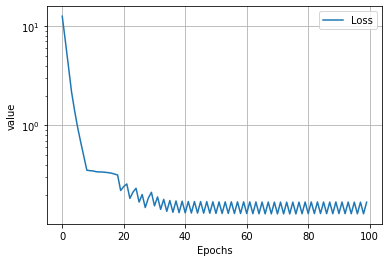

In [129]:
"""
Author: Fayyaz Minhas
"""
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.modules as nn
import torch.optim as optim

#Let's generate some data
Xp = 1.0+np.random.randn(10,2); Xn = -1.0-np.random.randn(100,2);
inputs = np.vstack((Xp,Xn))	
#labels
targets = np.hstack((np.ones(len(Xp)),-np.ones(len(Xn))))
ttargets = targets+0 #copy of true labels
targets[0:]=np.nan; #setting labels to unknown
targets[0]=1.0;targets[-1]=-1.0;#assume we only know two labels
#kernel 
from sklearn.metrics.pairwise import rbf_kernel
K = (np.dot(inputs,inputs.T)+1)**2
K = rbf_kernel(inputs)
K = torch.from_numpy(K).float() #kernel

device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
x = torch.from_numpy(inputs).float()
y = torch.from_numpy(targets).float()
N, D_in,D_out = x.shape[0], x.shape[1], 1
# Loss function implementation
def L1(z):
    g = 10
    zz = torch.zeros((2,len(z)))
    zz[1] = 1-z    
    closs = torch.logsumexp(g*zz,0)/g
    closs = torch.max(torch.Tensor([0]) , 1 - z) 
    return closs
def L2(z):
    #g = 10
    #zz = torch.zeros((2,len(z)))
    #zz[1] = z
    #az = (torch.logsumexp(-g*zz,0)+torch.logsumexp(g*zz,0))/g #smooth approximation of abs https://math.stackexchange.com/questions/728094/approximate-x-with-a-smooth-function
    #az = torch.logsumexp(g*zz,0)*2/g-z-(2/g)*torch.log(torch.tensor(2)) #smooth approximation of abs 
    #zz[1] = 1-az    
    #closs= torch.logsumexp(g*zz,0)/g #approx of max(0,1-abs(z))
    #closs = torch.exp(-3*(z**2)) #original approximation used in the paper 
    #closs = torch.exp(-0.5*(z**2)) #original approximation used in the paper "LARGE SCALE TRANSDUCTIVE SVMS"  by Collobert 2006    
    #closs= torch.max(torch.Tensor([0]) , 1 - torch.abs(z)) 
    s = -0.3
    closs = torch.min(torch.tensor(1+s),torch.max(torch.tensor(0),1-torch.abs(z)))
    return closs

eps = 1e-6
# Create random Tensors for weights; setting requires_grad=True means that we
# want to compute gradients for these Tensors during the backward pass.
wb = torch.randn(N, device=device, requires_grad=True)
wb = torch.tensor(torch.empty(N).normal_(mean=0.1,std=0.01), requires_grad=True)
# Parameters
learning_rate = 1e-2
lambda_w = 1e-1
lambda_u = 5e-1
lambda_b = 10e-1
cratio = np.mean(ttargets)
#Training 
optimizer = optim.SGD([wb], lr=learning_rate)
L = [] #history of losses
uidx, pidx, nidx = torch.isnan(y), y==1, y==-1
n_unsupv, n_pos, n_neg = torch.sum(uidx), torch.sum(pidx), torch.sum(nidx)
for epoch in range(100):
      """
      # REPRESENTATION
      """
      y_pred = wb@K
      """
      # EVALUATION
      """      
      loss_s, loss_u = 0.0,0.0
      if n_pos:
        loss_s = torch.mean(L1(y_pred[pidx]))
      if n_neg:
        loss_s+=torch.mean(L1(-1*y_pred[nidx]))
      if n_unsupv:
        loss_u = torch.mean(L2(y_pred[uidx]))/L2(torch.tensor([0]))
      balance = (torch.mean(y_pred[~uidx])-cratio)**2
      obj = loss_s+lambda_u*loss_u+lambda_w*wb@K@wb+lambda_b*balance #empirical loss + regularization     

      """
      #OPTIMIZATION
      """    
      obj.backward()
      # Using built-in optimizer
      optimizer.step()
      optimizer.zero_grad()
      L.append(balance.detach().numpy()) #save for history and plotting

wbn = wb.detach().numpy()
plt.close("all")
plt.plot(L);plt.yscale('log')

plt.grid(); plt.xlabel('Epochs'); plt.ylabel('value');plt.legend(['Loss','Objective'])
"""
def clf(inputs): 
  return inputs@wb

print("Predictions: ",clf(inputs))
print("Weights: ",wbn)
plt.figure()


plotit(inputs,targets,clf=clf,conts=[0],extent = [-5,+5,-5,+5])
"""

In [130]:
z = (wb@K).detach().numpy()
print("Accuracy",np.mean(z*ttargets>0))
from sklearn.metrics import roc_auc_score
print("AUROC",roc_auc_score(ttargets, z))

Accuracy 0.6181818181818182
AUROC 0.794


Text(0.5, 1.0, 'Prediction Scores')

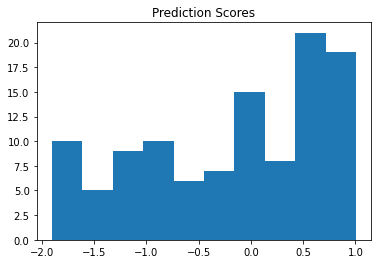

In [131]:
plt.hist(z);plt.title('Prediction Scores')

Text(0.5, 1.0, 'Sample Weighths')

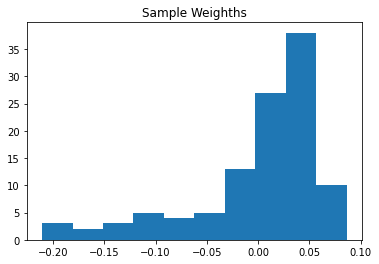

In [132]:
plt.hist(wbn);plt.title('Sample Weighths')

In [133]:
y

tensor([ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -1.])

In [134]:
ttargets

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.])

In [135]:
torch.mean(y_pred[~uidx]),cratio

(tensor(-0.4070, grad_fn=<MeanBackward0>), -0.8181818181818182)